## Features Engineering for Pairs Trading

We will use unsupervised learning to generate stock pairs suitable for pair trading strategies. Our initial focus will involve data preprocessing. The primary step entails dimension reduction via PCA. Then, we will create clusters of stocks using the DBSCAN algorithm. We can identify sutable pairs in each cluster by running a cointegration test.

In this notebook, we will perform the following steps:

1. [Read the Data](#data)
2. [Dimensionality Reduction using PCA](#pca)
3. [Combine the Fundamental Factors](#fundamental)
4. [Standardise the Data](#standardise)
2. [Create Clusters Using DBSCAN](#dbscan)
3. [Visualise the Clusters](#visualise)
4. [Create Pairs](#create-pairs)
2. [Function to Check for Cointegration](#co-int)

## Import Libraries

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# For data preprocessing
from sklearn.decomposition import PCA
from sklearn import preprocessing

# For clustering
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

# Pairs
from itertools import combinations

#For statistical tools
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

/var/folders/cp/bkd_fjpn4h3g5xz9g867z6cw0000gn/T/ipykernel_66606/1315039473.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<a id='data'></a> 
## Read the Data

Price data for 473 stocks within the S&P 500 index is stored in a CSV file named SP_500_data.csv. The dataset spans from January 2020 to July 2021. We can access this data by utilizing the read_csv method provided by the Pandas library.

Our analysis will encompass both price and fundamental data. To start, we compute the daily returns for each stock employing the pct_change function from the Pandas library.

In [2]:
# The data is stored in the directory 'data_modules'
path = './data_modules/'

# Read the data
returns_data = pd.read_csv(path + 'SP_500_data.csv', index_col=0)

# Calculate the percentage change
returns_data = returns_data.pct_change().dropna()
print("Shape of the data:", returns_data.shape)
returns_data.head()

Shape of the data: (344, 473)


,A,AAP,AAPL,ABBV,ABC,ABMD,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XLNX,XOM,XRAY,XYL,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-20,0.010645,-0.127254,-0.063485,-0.031523,-0.062675,-0.071169,-0.054006,-0.039576,-0.058016,-0.085176,...,0.115715,-0.126919,-0.047707,-0.049085,-0.065224,-0.070897,-0.035450,-0.030745,-0.061284,-0.013583
2020-03-23,-0.046494,0.046248,-0.021244,-0.062772,-0.082868,0.014022,-0.041683,0.040394,0.000940,-0.042470,...,0.107754,-0.012443,0.001948,-0.039401,-0.028032,-0.054266,-0.060130,-0.048277,-0.058640,-0.082029
2020-03-24,0.057283,0.100382,0.100325,0.046356,0.080076,0.085613,0.091586,0.008885,0.100634,0.102695,...,0.156158,0.081000,0.068195,0.126868,0.059875,0.094633,0.155798,0.057580,0.045681,0.119793
2020-03-25,0.029851,0.046191,-0.005509,0.006223,-0.056355,0.022412,-0.032069,-0.013194,0.006722,0.011758,...,0.127704,0.027752,-0.024574,0.052201,0.035197,0.030000,0.036724,0.031459,0.026608,0.042887
2020-03-26,0.068406,0.074693,0.052623,0.087174,0.116921,0.015522,0.128573,0.054787,-0.018440,0.053823,...,-0.047295,0.042484,0.070115,0.041030,0.128940,0.064986,0.044104,0.060570,0.058801,0.089641


<a id='pca'></a> 
## Dimensionality Reduction using PCA

Since the number of features is large in the data, we will reduce it such that the resulting data explains 90% variance of the original data.

In [3]:
# Number of components (Percentage of variance explained)
desired_variance = 0.90

# Instantiate a PCA object with n_components equal to the desired variance
pca = PCA(n_components=desired_variance)

# Fit PCA on the returns_data
pca.fit(returns_data)

# Principal component vectors
X = pca.components_
print("Number of features in the reduced dataset:", X.T.shape[1])

Number of features in the reduced dataset: 78


Hence, it is evident that the dataset opted for contains 78 principal components, chosen to achieve a desired explained variance of 90%.

Now, wecombine the chosen principal components with the fundamental data for each individual stock.

<a id='fundamental'></a> 
## Combine the Fundamental Data

The fundamental data for all the `473` stocks are stored in a CSV file `fundamentals.csv`. You have the values for `profitMargins`, `revenueGrowth` and `returnOnEquity`.

In [4]:
# Read the csv file using read_csv method of pandas 
data = pd.read_csv(path + 'fundamentals.csv', index_col=0)

# Join the fundamental data and the principal components
for col in data.columns:
    X = np.vstack((X,data[col].values))   

print("Shape of the final dataset:", X.T.shape)

Shape of the final dataset: (473, 81)


The number of columns in the dataset has increased from 78 to 81.

In [5]:
# Convert the data into a dataframe
X = pd.DataFrame(X.T, index=returns_data.columns)
X.columns = ["Feature_" + str(i) for i in range(1,82)]
X.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_72,Feature_73,Feature_74,Feature_75,Feature_76,Feature_77,Feature_78,Feature_79,Feature_80,Feature_81
A,0.024513,-0.047728,0.012189,0.011161,0.012913,-0.012946,0.044103,0.029851,-0.005108,-0.043074,...,-0.024990,0.020820,-0.007978,0.014990,-0.012895,-0.022593,0.016875,17.294000,9.6,47.467998
AAP,0.036051,-0.025795,-0.025765,-0.027625,-0.022082,0.002110,-0.024286,-0.034958,0.018286,0.080817,...,0.031044,-0.005729,0.035492,-0.010218,0.007201,0.004471,-0.001058,10.278000,50.9,163.563990
AAPL,0.023743,-0.077581,0.027674,0.008564,0.026343,-0.017604,-0.046218,-0.008045,0.002363,0.012450,...,0.042536,-0.004396,0.016324,0.036073,-0.044519,0.019626,-0.013355,26.610002,16.7,18.832001
ABBV,0.018119,-0.030860,-0.020158,0.033782,0.033787,0.019544,0.018505,0.031679,0.026793,-0.011362,...,0.009221,-0.082828,0.002874,-0.007810,0.040788,0.019352,-0.051413,12.051000,20.7,32.209998
ABC,0.029237,-0.026735,-0.057144,0.023817,0.010492,-0.000674,-0.011740,0.057613,0.058520,-0.022331,...,-0.020521,0.020482,0.005535,0.015096,-0.034337,-0.050567,0.005366,26.957000,27.2,16.302000


<a id='standardise'></a> 
## Standardise the Data

Below the summary statistics for each column of the dataset.

In [6]:
# Statistics of the dataset
np.round(X.describe(), 2)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_72,Feature_73,Feature_74,Feature_75,Feature_76,Feature_77,Feature_78,Feature_79,Feature_80,Feature_81
count,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,...,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00
mean,0.04,-0.02,-0.01,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,...,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,11.05,70.62,44.57
std,0.02,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,22.96,1108.43,263.70
min,-0.01,-0.13,-0.09,-0.16,-0.14,-0.13,-0.34,-0.12,-0.27,-0.43,...,-0.17,-0.14,-0.14,-0.16,-0.16,-0.14,-0.15,-234.95,-99.80,-560.55
25%,0.03,-0.05,-0.04,-0.02,-0.03,-0.03,-0.02,-0.02,-0.02,-0.02,...,-0.02,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,5.33,2.80,7.43
50%,0.04,-0.02,-0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,11.88,12.20,14.67
75%,0.05,0.01,0.01,0.02,0.03,0.03,0.02,0.03,0.03,0.03,...,0.03,0.03,0.02,0.03,0.03,0.03,0.03,18.97,27.20,28.04
max,0.12,0.13,0.27,0.26,0.19,0.20,0.11,0.24,0.21,0.17,...,0.16,0.19,0.25,0.16,0.17,0.16,0.18,151.73,24112.50,3835.34


In order to make the different columns comparable, we will standardise the data. This can be done by using the StandardScaler method of the sklearn library.

In [7]:
# Standardise the data
X = preprocessing.StandardScaler().fit_transform(X)

# Convert X into a dataframe
X = pd.DataFrame(X, index=returns_data.columns)
X.columns = ["Feature_" + str(i) for i in range(1,82)]

X.head()

# Tickers of the assets
tickers = X.index

<a id='dbscan'></a> 
## Create Clusters Using DBSCAN

We will use the DBSCAN algorithm to create clusters. You can use the DBSCAN function from the sklearn library for this. Set the distance parameter eps to 5 and the minimum number of samples min_samples to 3. You can find out which cluster a stock belongs to by checking the label_ property of the DBSCAN object. If a stock has a label of -1, it means it's considered noise in the dataset and isn't assigned to any cluster.

In [8]:
# Instantiate a DBScan object
dbscan = DBSCAN(eps=5, min_samples=3)

# Fit dbscan on X
dbscan.fit(X)

# Labels of the cluster
labels = dbscan.labels_

In [9]:
# Number of clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)


Clusters discovered: 9


From the provided settings of eps and min_samples, you can observe that the dataset has yielded a total of 9 clusters. Each of these clusters contains a minimum of 3 stocks. Furthermore, it's worth noting that the greatest distance between points within the same cluster measures 5 units.

In [10]:
# Create a series with cluster labels
clustered_series_all = pd.Series(index=tickers, data=labels.flatten())

# Remove the data points with label '-1' as they are the noise 
clustered_series = clustered_series_all[clustered_series_all != -1]

<a id='visualise'></a> 
## Visualise the Clusters

We can reduce the dimension from `81`(`81`features) to `2` for representation.

This can be done by using the `TSNE` method of the `sklearn` library. The t-Distributed Stochastic Neighbor Embedding (TSNE) plots a high-dimensional dataset in a lower-dimensional space. 

In [11]:
X_tsne = TSNE(n_components=2, 
              learning_rate=100, 
              perplexity=25, 
              random_state=7).fit_transform(X)
print(X_tsne[:5])

[[ -0.26896027  13.44048   ]
 [  0.58597934 -13.768963  ]
 [  7.844778   -12.909773  ]
 [  1.6603439   19.599028  ]
 [-22.946241    -5.8822875 ]]


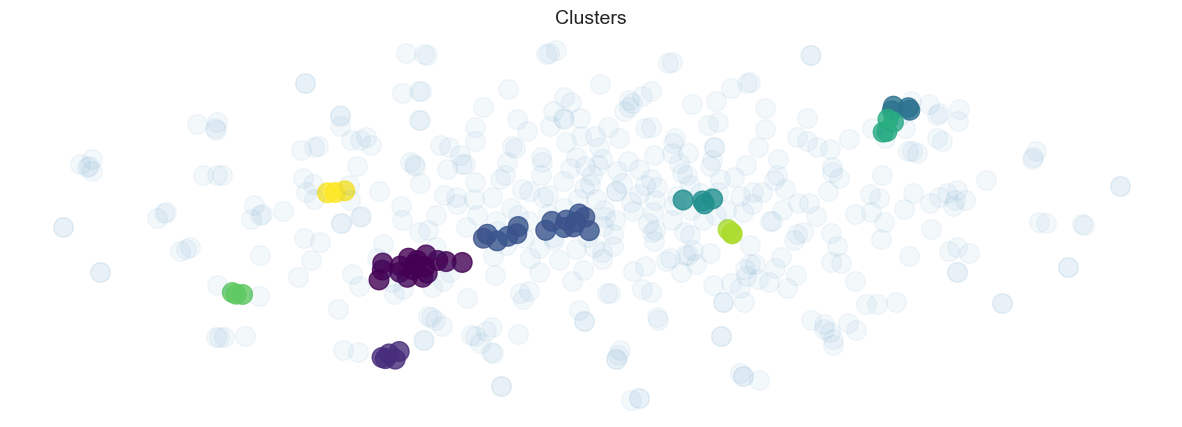

In [12]:
# Create the figure
plt.figure(1, facecolor='white', figsize=(15,5))
plt.axis('off')

# Plot the clusters
plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=200,
    alpha=0.8,
    c=labels[labels!=-1],
    cmap='viridis'
)

# Plot the noise
plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=200,
    alpha=0.05
)

# Set the title
plt.title('Clusters', fontsize=14)
plt.show()

In the above plot, we can see the nine clusters. The greyed out points are the points with the cluster label `-1`, i.e. the noise. 

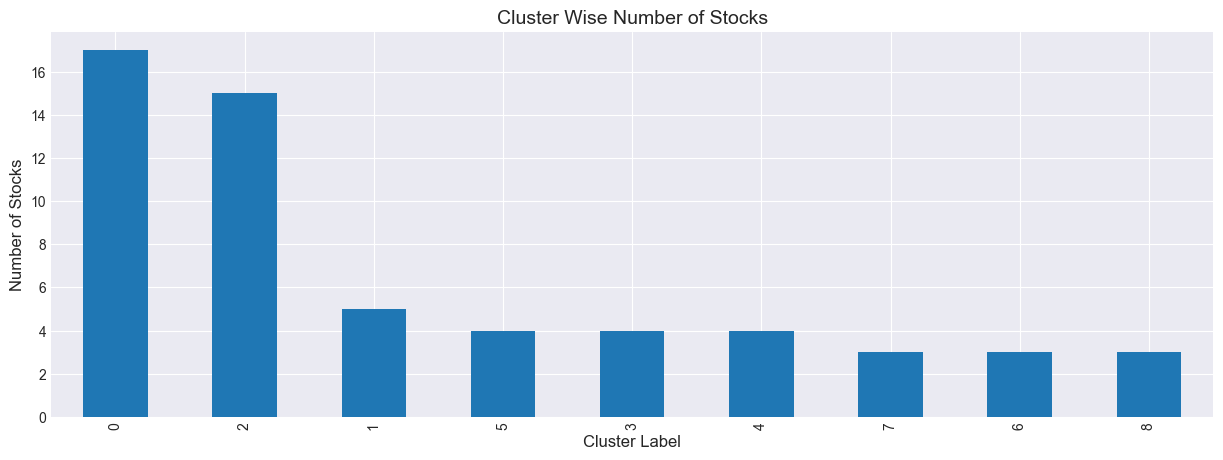

In [13]:
# Plot the bar graph for the number of stocks in each cluster
clustered_series.value_counts().plot.bar(figsize=(15, 5))

# Set title and axis label
plt.title("Cluster Wise Number of Stocks", fontsize=14)
plt.xlabel("Cluster Label", fontsize=12)
plt.ylabel("Number of Stocks", fontsize=12)
plt.show()

From the above graph, you can see that the cluster with label `0` has `17` stocks, `1` has `5`, `2` has `15`, and so on. 

<a id='create-pairs'></a> 
## Create Pairs

We will contitute all possible pairs in each cluster.

#### Cluster Wise Pairs

In [14]:
# Dictionary to store pairs
stocks_pair = {}
list_pairs = []

pair_no = 0

# Create pairs
for i in range (0, n_clusters_):
    pairs = list(list(combinations(clustered_series[clustered_series == i].index, 2)))
    stocks_pair[i] = pairs
    for pair in pairs:
        list_pairs.append([pair_no,pair[0],pair[1]])
        pair_no +=1

        
# Convert the dictionary into a dataframe
stocks_pairs = pd.DataFrame.from_dict(stocks_pair.items())
stocks_pairs.rename(columns={0:'Cluster No.', 1: "Pairs"}, inplace=True)
stocks_pairs = stocks_pairs.set_index('Cluster No.')

stock_pair = pd.DataFrame(list_pairs, columns=['Pair No.','Stock 1', 'Stock 2'])

# Number of pairs in a cluster
stocks_pairs['Number of Pairs'] = stocks_pairs['Pairs'].apply(lambda x:len(x))

stock_pair.set_index('Pair No.', inplace=True)

In [15]:
# Read the data
SP_500_data = pd.read_csv(path + 'SP_500_data.csv', index_col=0)

<a id='co-int'></a> 
## Function to Check for Cointegration

The steps to check for cointegration are as follows:
1. **Read the data for the two price series**

2. **Create a portfolio:** Use the linear regression model between the two stocks to calculate the hedge ratio. Calculate the spread using this ratio.

3. **Calculate the test statistics using the ADF test** 
4. Return `True` if the series is cointegrated, otherwise `False`.

In [16]:
def is_coint(pair):
    """Function to check for cointegration
    """
    
    # Data for the two stocks in pair 
    data = pd.DataFrame()
    data['stock_1'] = SP_500_data[pair[0]]
    data['stock_2'] = SP_500_data[pair[1]]
    data = data.dropna()

    # Create a portfolio using a hedge ratio obtained using linear regression
    model = sm.OLS(data['stock_1'], data['stock_2'])
    model = model.fit() 
    portfolio = (data['stock_1'] - model.params[0] * data['stock_2'])

    # Calculate the test statistics and print the results at 90% level of confidence
    result = ts.adfuller(portfolio)
    
    # Return True if the pair is cointegrated, else False
    if result[0] < result[4]['10%']:
        return True
    else:
        return False
    

# Create a column to store whether the pair is cointegrated
stock_pair['cointegrated'] = stock_pair.apply(is_coint, axis=1)

# Cointegrated pairs
final_pairs = stock_pair[stock_pair['cointegrated'] == True]
final_pairs.head()

,Stock 1,Stock 2,cointegrated
Pair No.,,,
8,AEE,ETR,True
10,AEE,LNT,True
12,AEE,PNW,True
15,AEE,XEL,True
16,AEP,ATO,True


In [17]:
print("Total number of cointegrated pairs: ", final_pairs.shape[0])

Total number of cointegrated pairs:  55


## Conclusion

At a 90% level of confidence, 55 pairs are found to be cointegrated. 